# Preamle

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import matplotlib.colors as colors
import datetime as dt
from matplotlib.colors import BoundaryNorm
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

import calendar
import sys
from importlib import reload
sys.path.append('/home/563/ab2313/MJO/functions')
import load_dataset as load
import subphase_calc_functions as subphase_calc
import access_functions as af

import correlation_plots as corr_plot

import access_correlation_functions as access_corr

In [2]:
load = reload(load)
awap, access, rmm_obs, rmm_access = load.load_accessifies_variables()

4159 4159
4159 4159


In [3]:
subphase_calc = reload(subphase_calc)
# Split AWAP into the subphases: enhanced, suppressed, transition and inactive.
awap_split = subphase_calc.split_into_subphase(awap, rmm_obs)

In [4]:
subphase_calc = reload(subphase_calc)
# Split access into the subphases: enhanced, suppressed, transition and inactive.
access_split = af.access_rmm_split(access, rmm_access)

1 2 3 4 5 6 7 8 9 10 11 

In [5]:
access_split

<xarray.Dataset>
Dimensions:   (ensemble: 11, lat: 49, lon: 149, phase: 4, time: 4159)
Coordinates:
  * lon       (lon) float32 113.75 114.0 114.25 114.5 ... 150.25 150.5 150.75
  * lat       (lat) float32 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * time      (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2012-12-31
  * phase     (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    precip    (ensemble, phase, time, lat, lon) float32 nan nan nan ... nan nan
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...
    Time:         Only for the wet-season

# Functions

In [6]:
def fisher_z(data):
    
    # Converting all the data to a z-space
    z_space = 0.5 * np.log((1 + data.precip)/(1- data.precip)).to_dataset(name = 'z_val')

    # Taking the mean across the north of Australia
    z_mean = z_space.mean(dim = ['lat','lon'])

    #Getting the mean of all these values
    rho_mean = np.tanh(z_mean.z_val)
    
    return rho_mean
    

In [7]:
def fisher_z_state(data_total): # The mean of all correlation values for each state using the fisher-z transfomr
    
    states = [slice(110,160),slice(110,129),slice(130,138), slice(138, 160)] #Lons for All,WA, NT and QLD respectivly
        
    state_stor = []    

    for state in states:
        data = data_total.sel(lon = state)
        
        # Converting all the data to a z-space
        z_space = 0.5 * np.log((1 + data.precip)/(1- data.precip)).to_dataset(name = 'z_val')

        
        # Taking the mean across the north of Australia
        z_mean = z_space.mean(dim = ['lat','lon'])
        
        #Getting the mean of all these values
        rho_mean = np.tanh(z_mean.z_val)
        
        state_stor.append(rho_mean)
    print(len(state_stor))
    state_means = xr.concat(state_stor, pd.Index(['All','WA','NT','QLD'], name = 'state'))
    return state_means
    

In [8]:

# All of the following need two functions, the second is to apply the second groupy (groupy year)

def group_count(group):
    return group.groupby('time.year').count()


def group_resample_count(data):
    rain_year = data.groupby('time.month').apply(group_count)

    
    return rain_year




def group_resample_mean_2(group):
        return group.groupby('time.year').mean()

def group_resample_mean(group):
        return group.groupby('time.month').apply(group_resample_mean_2)
    
    
    
    

def group_resample_sum_2(group):
        return group.groupby('time.year').sum()

def group_resample_sum(group):
        return group.groupby('time.month').apply(group_resample_sum_2)

In [9]:
def awap_access_correlation(awap, access):
    
    # Finding the mean across the dimension year
    awap_mean = awap.mean(dim = 'year')
    access_mean = access.mean(dim = 'year')
    
    # Taking the mean from all of the values
    awap_y_sub_mean = awap - awap_mean 
    access_y_sub_mean = access - access_mean 
    
    
    # The covarience: the sum of the product, divfided by the number of samples -1
    cov = (awap_y_sub_mean * access_y_sub_mean).sum(dim = 'year')/(awap_y_sub_mean.count(dim = 'year') - 1)
    
    # the standsard deviation
    awap_std = awap.std(dim = 'year')
    access_std = access.std(dim = 'year')

    # Correlation: cross-covarience divided by the number of samples
    rho = cov/(awap_std * access_std)

    return rho

# Percent

Note: In this calculation everything is called count, although it shoudl actually be percent

## Calculation

### Correlation

<b> Calculating the number of days in RMM </b>

In [59]:

def rmm_count_resample(group):
    return group.groupby('time.year').count(dim = 'time')


def count_in_rmm_subphase_year_month_resample(rmm):
    
    enhanced = [5,6,7]
    suppressed = [1,2,3]
    transition = [4,8]

    phase_dict =  {'enhanced': enhanced, 'suppressed': suppressed, 'transition': transition}
    single_phase = []
    
    rmm_act = rmm.where(rmm.amplitude > 1, drop = True)

    for phase_name, phase_nums in phase_dict.items():

         # Just the data for this single rmm phase
        rmm_single_phase = rmm_act.where(rmm_act.phase.isin(phase_nums))#, drop = True)
         # Resmapling via year, to get the number of days in each phase
        number_per_year = rmm_single_phase.phase.groupby('time.month').apply(rmm_count_resample)
        # Appending
        single_phase.append(number_per_year)



    '''Inactive Phase'''
    rmm_inact = rmm.where(rmm.amplitude <=1)# , drop = True)
    number_per_year_inact = rmm_inact.phase.groupby('time.month').apply(rmm_count_resample)

    single_phase.append(number_per_year_inact)

    titles = np.append(np.array([key for key in phase_dict.keys()]),['inactive'])

    phase_resamples = xr.concat(single_phase, pd.Index(titles, name = 'phase')).to_dataset(name = 'precip')
    
    
#     datafile_RMM_split = xr.concat(single_phase, pd.Index(titles, name = 'phase'))
    
    return phase_resamples 


In [85]:
import access_general_functions as access_general

In [86]:
access_general = reload(access_general)
rmm_count_obs  = access_general.count_in_rmm_subphase_year_month_resample(rmm_obs)

AttributeError: module 'access_general_functions' has no attribute 'count_in_rmm_subphase_year_month_resample'

In [87]:
rmm_count_obs

<xarray.Dataset>
Dimensions:  (month: 6, phase: 4, year: 23)
Coordinates:
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2008 2009 2010 2011 2012
  * month    (month) int64 1 2 3 10 11 12
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    precip   (phase, month, year) float64 16.0 3.0 7.0 10.0 ... 12.0 9.0 22.0

<b> AWAP </b>

In [205]:
access_corr = reload(access_corr)
count_anom = access_corr.count_month_year_anomalies(awap_split, awap, rmm_count_obs)

In [206]:
count_anom

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, month: 6, phase: 4, year: 23)
Coordinates:
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2008 2009 2010 2011 2012
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * month    (month) int64 1 2 3 10 11 12
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
Data variables:
    precip   (month, year, phase, lat, lon) float64 nan 1.761 1.761 ... nan nan

<b> ACCESS-S </b>

In [207]:
access_general = reload(access_general)
access_corr = reload(access_corr)
count_anom_ens, count_anom_ens_med = \
                access_general.access_ensemble_calculation(access_split, access, rmm_access,
                                                           access_corr.count_month_year_anomalies)

<b> Different Correlatin Calculations

In [273]:
access_corr = reload(access_corr)
spearman_percent, sig_percent = access_corr.spearman_correlation(count_anom,count_anom_ens_med)

In [275]:
rho_percent = awap_access_correlation(count_anom,count_anom_ens_med)

In [276]:
rho_percent

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, month: 6, phase: 4)
Coordinates:
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * month    (month) int64 1 2 3 10 11 12
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
Data variables:
    precip   (month, phase, lat, lon) float64 nan 0.2163 -0.07636 ... nan nan

Fisher-Z transform

In [331]:
rho_p_mean = fisher_z(rho_percent)

rho_p_mean

<xarray.DataArray 'z_val' (month: 6, phase: 4)>
array([[ 0.05717604,  0.11773543,  0.21203251,  0.23044617],
       [ 0.39986689,  0.31350351,  0.15017629,  0.07866268],
       [ 0.1426027 ,  0.18425664,  0.32603469,  0.17071904],
       [ 0.07026754,  0.09178358,  0.16922195,  0.13422582],
       [ 0.14078085,  0.25637947,  0.07295879,  0.02727393],
       [ 0.24231995,  0.16524293, -0.00751305,  0.26302949]])
Coordinates:
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * month    (month) int64 1 2 3 10 11 12

In [417]:
rho_p_state = fisher_z_state(rho_percent)
rho_p_state

4


<xarray.DataArray 'z_val' (state: 4, month: 6, phase: 4)>
array([[[ 0.05717604,  0.11773543,  0.21203251,  0.23044617],
        [ 0.39986689,  0.31350351,  0.15017629,  0.07866268],
        [ 0.1426027 ,  0.18425664,  0.32603469,  0.17071904],
        [ 0.07026754,  0.09178358,  0.16922195,  0.13422582],
        [ 0.14078085,  0.25637947,  0.07295879,  0.02727393],
        [ 0.24231995,  0.16524293, -0.00751305,  0.26302949]],

       [[-0.12801716,  0.1277538 ,  0.22246126,  0.08139913],
        [ 0.39458566,  0.24334898,  0.0838464 ,  0.06598894],
        [ 0.05293307,  0.07632008,  0.21538828,  0.21508463],
        [ 0.12018903,  0.20072392,  0.19444401,  0.25310835],
        [ 0.1351443 ,  0.16270163,  0.05569264, -0.13749079],
        [ 0.35327784,  0.30313695,  0.06727183,  0.33322014]],

       [[ 0.06684425,  0.09317558,  0.24568574,  0.27500645],
        [ 0.47838734,  0.42578562,  0.2272953 ,  0.08079144],
        [ 0.23146124,  0.30077934,  0.41727531,  0.12326145],
        [ 0.07671091,  0.06732857,  0.20502975,  0.10469285],
        [ 0.13322033,  0.31139832,  0.08816323,  0.11744259],
        [ 0.1181064 , -0.01032347, -0.1415187 ,  0.22004815]],

       [[ 0.21033657,  0.13462783,  0.16345952,  0.30562643],
        [ 0.31960036,  0.2673087 ,  0.1230455 ,  0.09220403],
        [ 0.13352516,  0.18315726,  0.31970311,  0.18960798],
        [ 0.03675827,  0.0299561 ,  0.10958188,  0.04709123],
        [ 0.1585051 ,  0.28270279,  0.08040609,  0.09035233],
        [ 0.25343997,  0.21797891,  0.06578485,  0.24046628]]])
Coordinates:
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * month    (month) int64 1 2 3 10 11 12
  * state    (state) object 'All' 'WA' 'NT' 'QLD'

## Maps

In [296]:
savedir_percent = 'plots_3/correlation/'

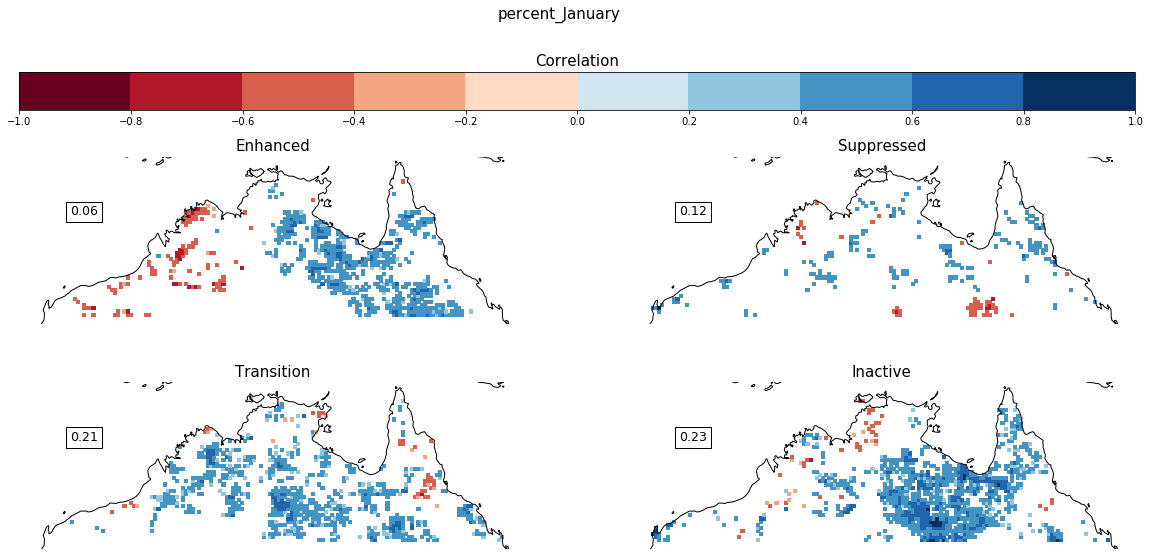

In [319]:
corr_plot = reload(corr_plot)
month = 1
save_name = f'percent_{calendar.month_name[month]}'
corr_plot.corr_plot_sig_only(spearman_percent.sel(month = month), # Correlation values
                    sig_percent.sel(month = month), # The location of the significant points
                    means = rho_p_mean.sel(month = month), # The mean for the phase
                    sig_size = 4.5, add_white = 0, extender = 0, # some mods
                    savetitle = save_name)

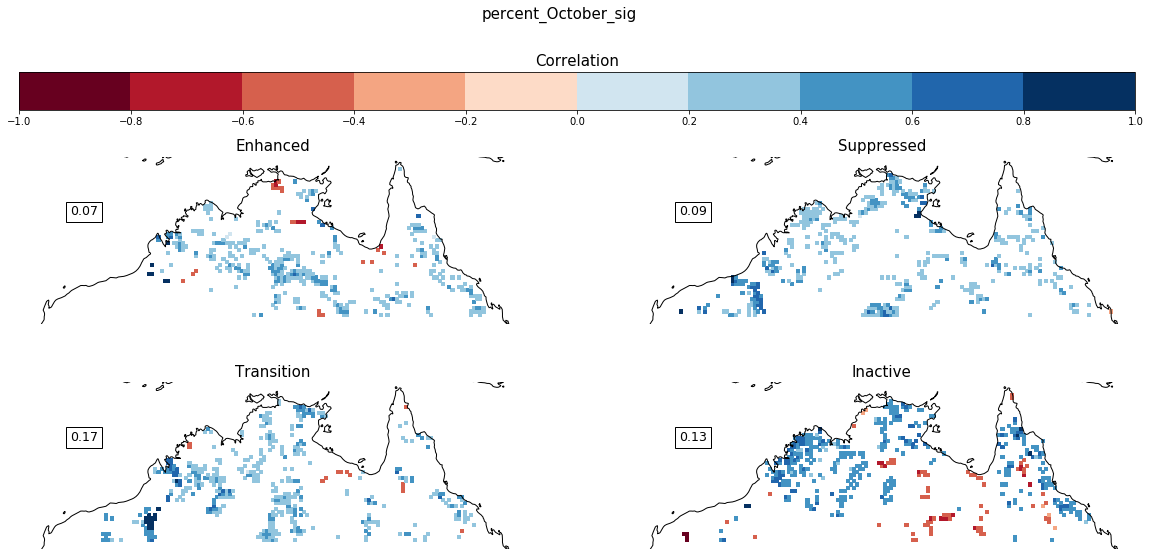

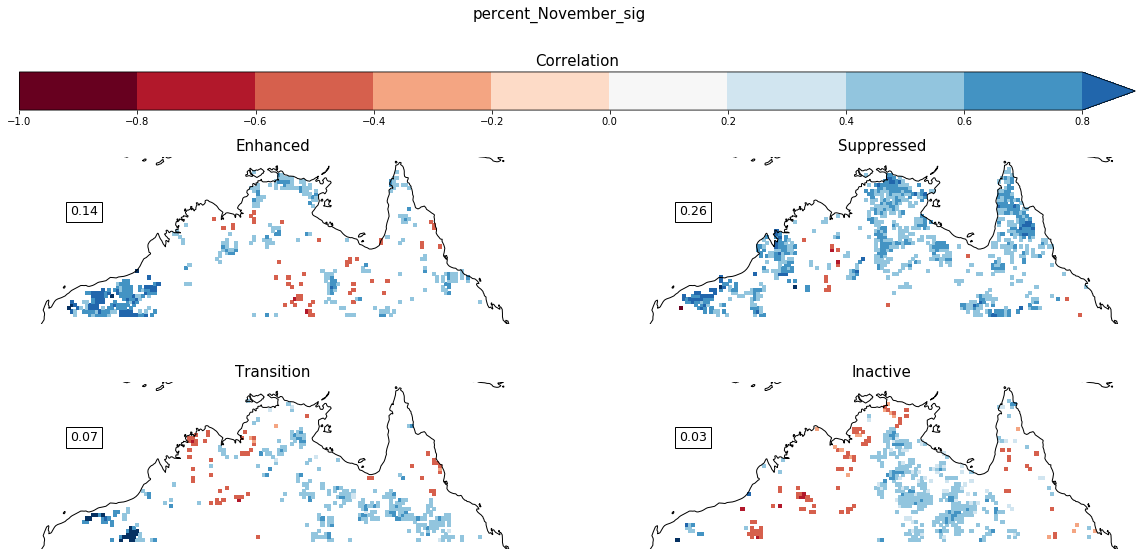

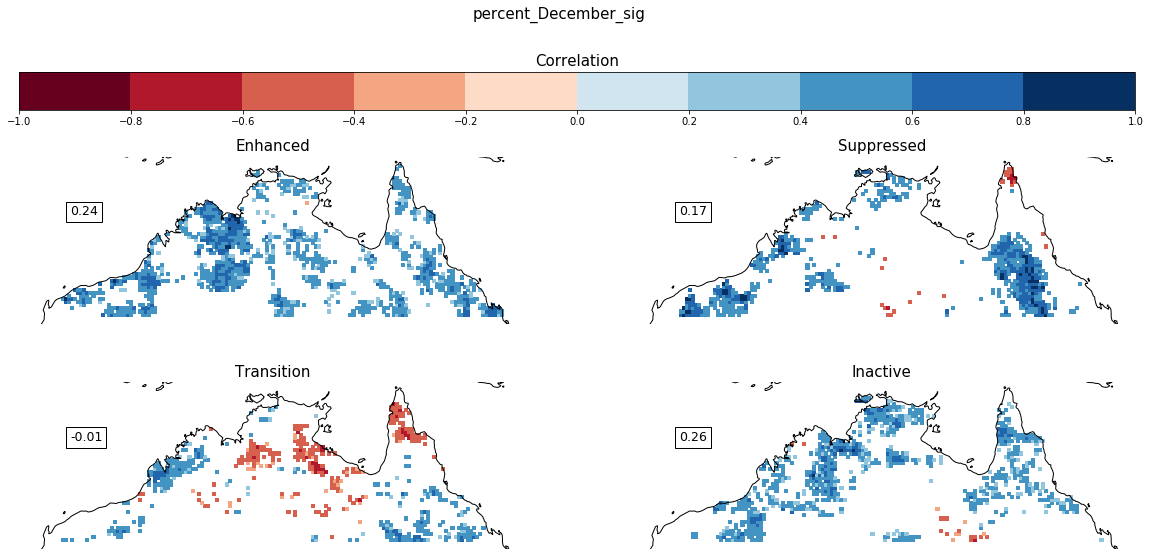

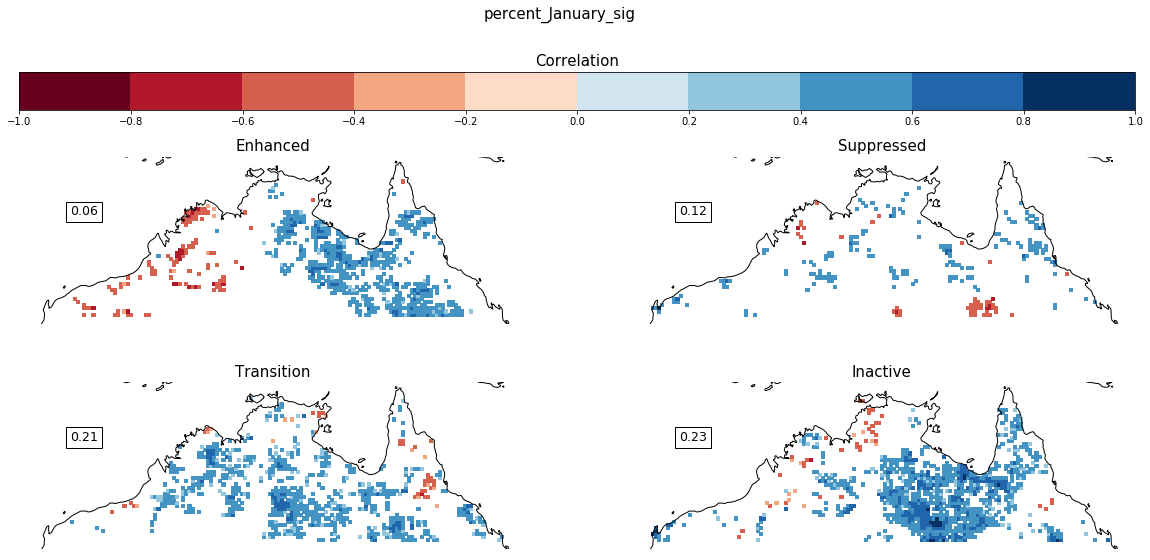

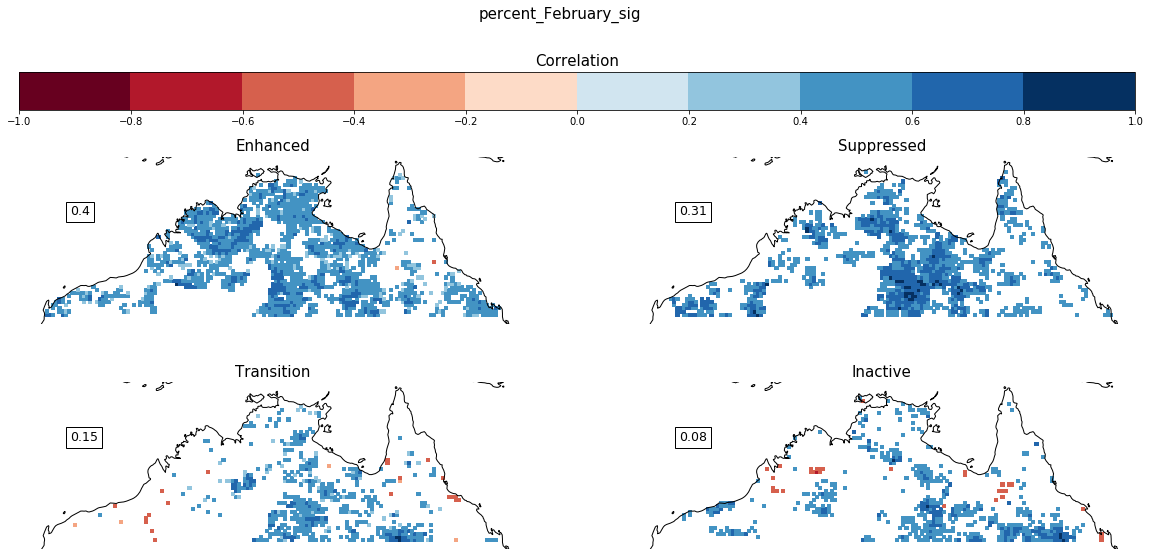

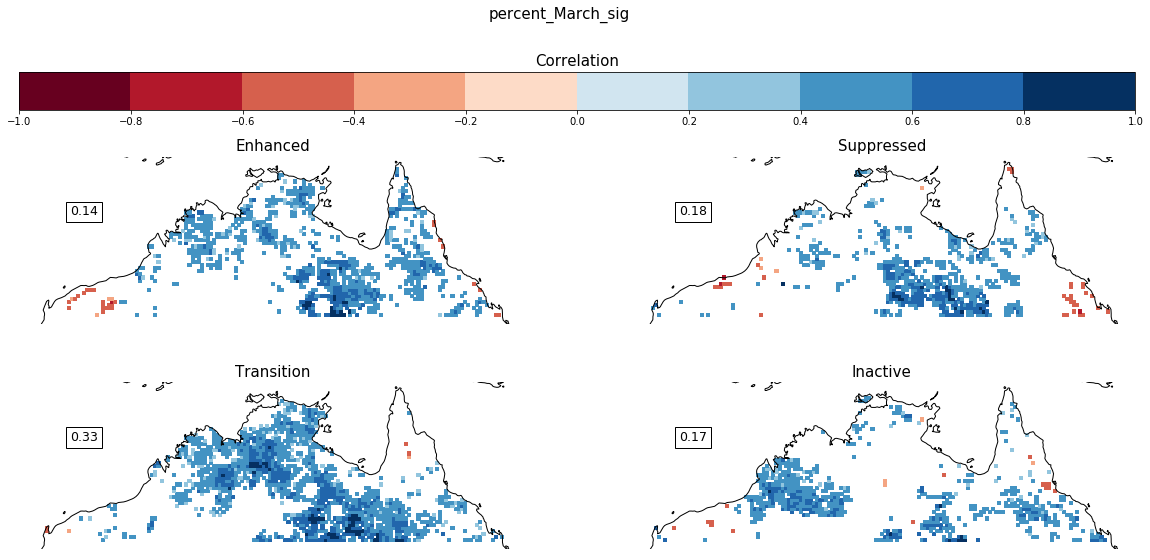

In [323]:
corr_plot = reload(corr_plot)
for month in [10,11,12,1,2,3]:
    save_name = f'percent_{calendar.month_name[month]}_sig'
    corr_plot.corr_plot_sig_only(spearman_percent.sel(month = month), 
                        sig_percent.sel(month = month),
                        means = rho_p_mean.sel(month = month)
                        ,savetitle = save_name, savedir = savedir_percent)

## Heatmaps

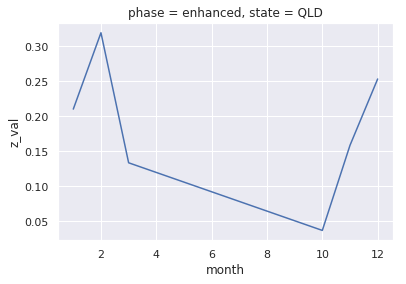

In [405]:
data_tot.sel(phase = 'enhanced', state = 'QLD').plot()

In [443]:
def custom_cmap(levels, add_white = 0, extender = 0):
    
    
    import matplotlib.colors as mpc
    
    cmap = plt.cm.RdBu

    
    # For this plot, in order for the stippling to be seen, the dark colors at the end need to be clipped off
    # This is doen be extending the cmap further on either side, then clipping the ends off
     # This is the extra amount of discrete colors to make
        # List  of all the colors
    custom_cmap = plt.cm.get_cmap('RdBu', len(levels) + extender)(np.arange(len(levels) + extender)) 
    if extender: # Chopping of some colors that are to dark to see the stippling
        custom_cmap = custom_cmap[extender:-extender] # CLipping the ends of either side
    
    if add_white:
        upper_mid = np.ceil(len(custom_cmap)/2)
        lower_mid = np.floor(len(custom_cmap)/2)
        white = [1,1,1,1]


        custom_cmap[int(upper_mid)] = white
        custom_cmap[int(lower_mid)] = white
        custom_cmap[int(lower_mid) - 1] = white
    
    cmap = mpc.LinearSegmentedColormap.from_list("RdWtBu", custom_cmap,len(levels)) 
    # Joingi the colormap back together
    
    
    return cmap

In [446]:
vmax = 0.5
vmin = -vmax
step = 0.1
levels = np.arange(vmin, vmax + step, step)
cmap = custom_cmap(levels, add_white = 1)

In [523]:
savedir = 'plots_3/correlation/'

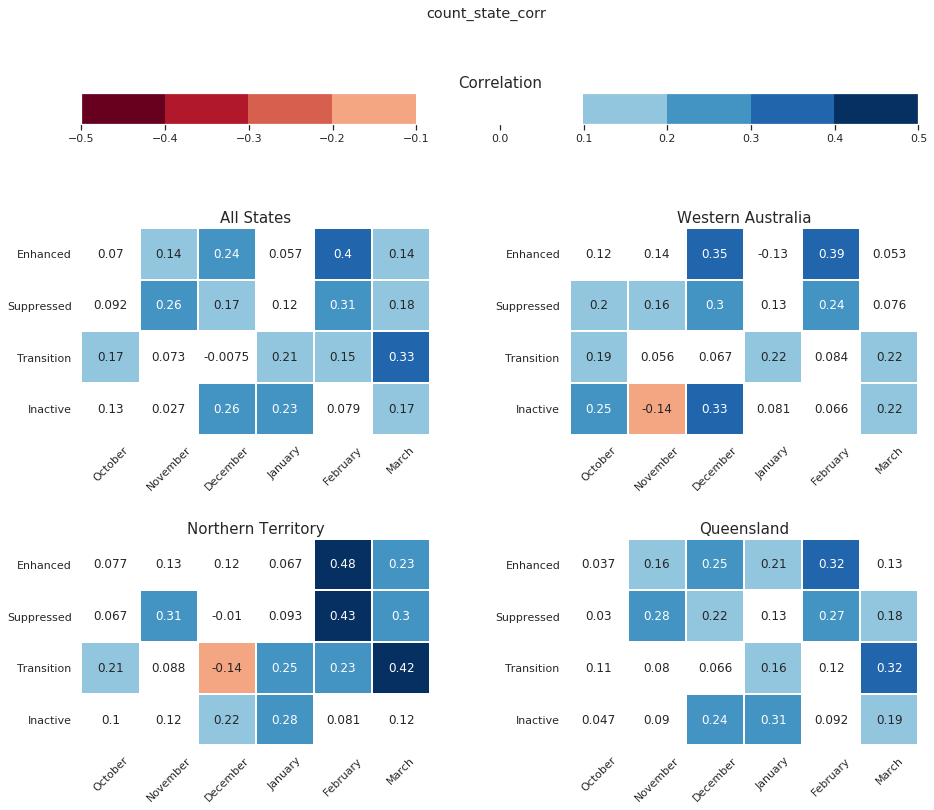

In [524]:
fig = plt.figure(figsize = (15, 12))

gs = gridspec.GridSpec(3,2, hspace = 0.7, wspace = 0.4, height_ratios = [0.15,1,1])

data_tot = rho_p_state

suptitle = 'count_state_corr'
fig.suptitle(suptitle)

for plot_num, state in enumerate(data_tot.state.values):

    
    state_id = {'All':'All States','NT':'Northern Territory','QLD':'Queensland','WA':'Western Australia'}
    
    ax = fig.add_subplot(gs[plot_num + 2])


    data = data_tot.sel(state = state)
    plot_vals = np.transpose(data.values)

    # Making sure the months are in the correct order: not 1,2,3,10,11,12
    plot_vals = np.concatenate([plot_vals[:,3:], plot_vals[:,0:3]], axis = 1)

    # ax.imshow(data, cmap = 'RdBu', vmin = -1, vmax = 1)

    sns.heatmap(plot_vals, ax = ax,
                cmap = cmap, vmax = 0.5, vmin = -0.5, cbar = False, 
               annot = True, linewidths = 1)

    ax.set_yticklabels(np.char.capitalize(data.phase.values.astype(str)), rotation = 360);
    month_names = [calendar.month_name[i] for i in data.month.values]
    month_names= np.concatenate([month_names[3:], month_names[0:3]])
    ax.set_xticklabels(month_names, rotation = 45);
    
    ax.set_title(state_id[state], fontsize = 15, pad = 5)
    
# 

ax = fig.add_subplot(gs[0])
pdata = ax.imshow(np.transpose(data.values), vmin = vmin, vmax = vmax, cmap = cmap)


axes = plt.subplot(gs[0:2])
cbar = plt.colorbar(pdata, cax = axes, orientation = 'horizontal',
                    ticks  = levels, boundaries = levels)
cbar.ax.set_title('Correlation', fontsize = 15);

fig.savefig(savedir + suptitle + '.png', dpi = 500)

In [527]:
data_tot.sel(phase = 'enhanced').values.shape

(4, 6)

In [539]:
list(state_id.values())

['All States', 'Northern Territory', 'Queensland', 'Western Australia']

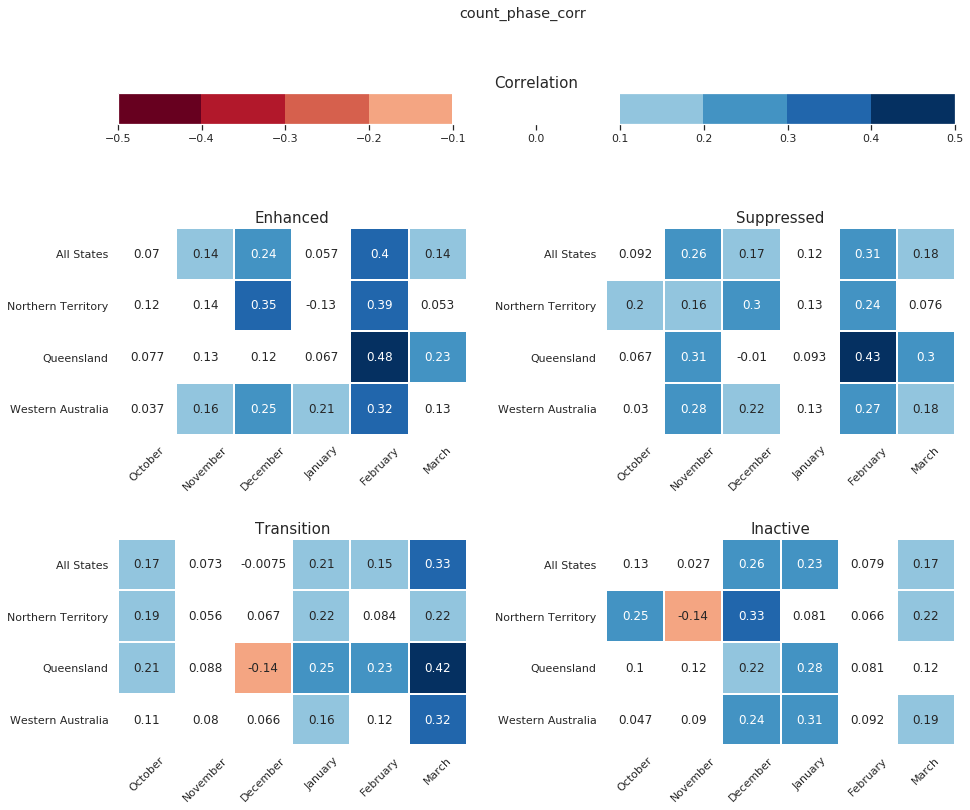

In [541]:
fig = plt.figure(figsize = (15, 12))

gs = gridspec.GridSpec(3,2, hspace = 0.7, wspace = 0.4, height_ratios = [0.15,1,1])

data_tot = rho_p_state

suptitle = 'count_phase_corr'
fig.suptitle(suptitle)

state_id = {'All':'All States','NT':'Northern Territory','QLD':'Queensland','WA':'Western Australia'}

for plot_num, phase in enumerate(data_tot.phase.values):

    

    
    ax = fig.add_subplot(gs[plot_num + 2])


    data = data_tot.sel(phase = phase)
    plot_vals = data.values

    # Making sure the months are in the correct order: not 1,2,3,10,11,12
    plot_vals = np.concatenate([plot_vals[:,3:], plot_vals[:,0:3]], axis = 1)

    # ax.imshow(data, cmap = 'RdBu', vmin = -1, vmax = 1)

    sns.heatmap(plot_vals, ax = ax,
                cmap = cmap, vmax = 0.5, vmin = -0.5, cbar = False, 
               annot = True, linewidths = 1)

    ax.set_yticklabels(list(state_id.values()), rotation = 360);
    month_names = [calendar.month_name[i] for i in data.month.values]
    month_names= np.concatenate([month_names[3:], month_names[0:3]])
    ax.set_xticklabels(month_names, rotation = 45);
    
    ax.set_title(phase.capitalize(), fontsize = 15, pad = 5)
    
# 

ax = fig.add_subplot(gs[0])
pdata = ax.imshow(np.transpose(data.values), vmin = vmin, vmax = vmax, cmap = cmap)


axes = plt.subplot(gs[0:2])
cbar = plt.colorbar(pdata, cax = axes, orientation = 'horizontal',
                    ticks  = levels, boundaries = levels)
cbar.ax.set_title('Correlation', fontsize = 15);

fig.savefig(savedir + suptitle + '.png', dpi = 500)

# Count

## Calculation

In [171]:
awap_y_count = awap_split.apply(group_resample_count)
awap_y_count

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, month: 6, phase: 4, year: 23)
Coordinates:
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2008 2009 2010 2011 2012
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * month    (month) int64 1 2 3 10 11 12
Data variables:
    precip   (phase, month, lat, lon, year) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0

In [172]:
access_y_count = access_split.apply(group_resample_count).median(dim = 'ensemble')
access_y_count

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, month: 6, phase: 4, year: 23)
Coordinates:
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2008 2009 2010 2011 2012
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * lon      (lon) float32 113.75 114.0 114.25 114.5 ... 150.25 150.5 150.75
  * lat      (lat) float32 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * month    (month) int64 1 2 3 10 11 12
Data variables:
    precip   (phase, month, lat, lon, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

## Correlation

Applying Scotts Correlation Function

In [196]:
a = awap_y_count
b = access_y_count

len_a = a.dims['year']
combined = xr.concat([a,b], dim='year')

# Helper function to split back into parts
def helper(x):
    from scipy.stats import spearmanr
    # Split 'x' into 'a' and 'b' parts
    xa = x[0:len_a]
    xb = x[len_a:]

    # Then process
    return spearmanr(xa, xb)[0]

axis = combined.precip.get_axis_num('year')
result = np.apply_along_axis(helper, arr = combined.precip, axis = axis)

In [197]:
result.shape

(4, 6, 49, 149)

In [174]:
def helper(x, len_a):
    # split x into 'a' and 'b' parts
    from scipy.stats import spearmanr

    xa = x[0:len_a]
    xb = x[len_a:]
    
    corr,sig = spearmanr(xa,xb)
    return corr, sig

In [175]:
len_a = awap_y_count.dims['year']

count_concat = xr.concat([awap_y_count,access_y_count], dim = 'year')

axis =  count_concat.precip.get_axis_num('year')
arr = count_concat.precip
spearman_count_meta = np.apply_along_axis(helper, arr = arr, 
                                     axis = axis)

spearman_count = xr.Dataset({'precip':(('phase','month','lat','lon'), spearman_count_meta)},{
    'phase':awap_y_count.phase.values,
    'month':awap_y_count.month.values,
    'lat':awap_y_count.lat.values,
    'lon':awap_y_count.lon.values
})

KeyboardInterrupt: 

In [162]:
spearman_count

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, month: 6, phase: 4)
Coordinates:
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * month    (month) int64 1 2 3 10 11 12
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
Data variables:
    precip   (phase, month, lat, lon) float64 nan 0.06674 -0.04679 ... nan nan

In [199]:
savedir_count = 'plots_2/correlation/count/'

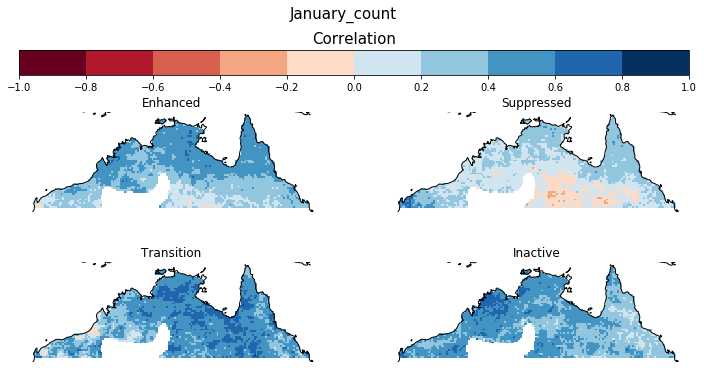

In [204]:
corr_plot = reload(corr_plot)
month = 1
save_name = f'{calendar.month_name[month]}_count'
corr_plot.corr_plot(spearman_count.sel(month = month), 
                    savetitle = save_name)

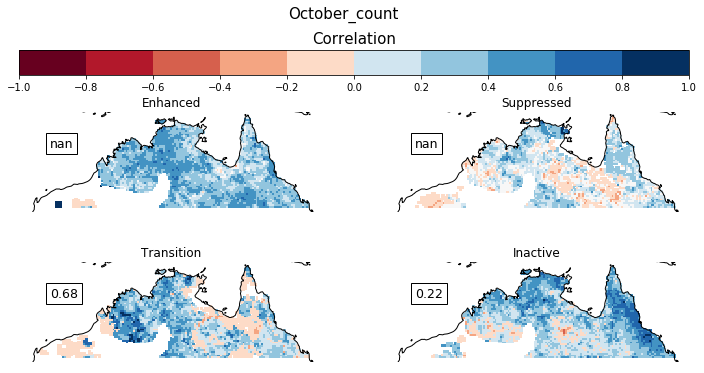

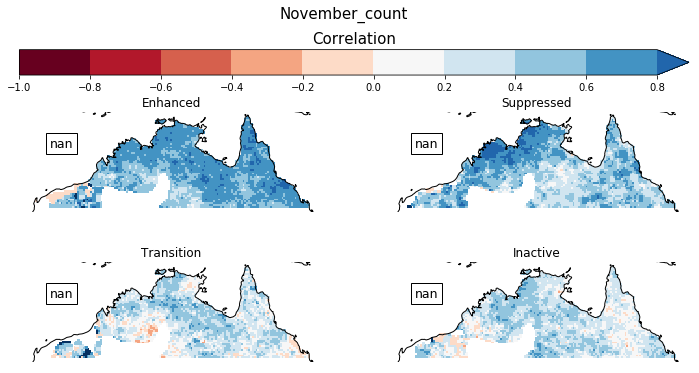

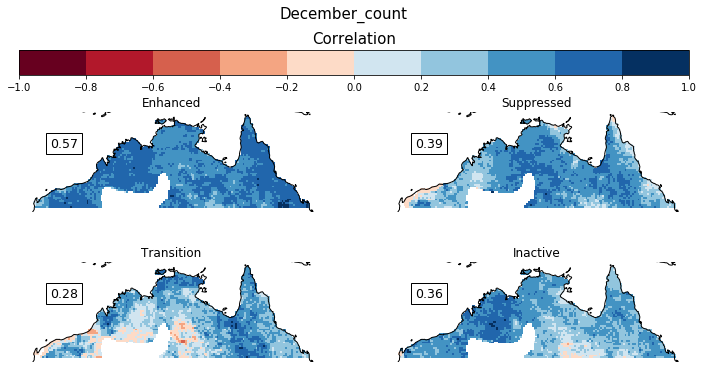

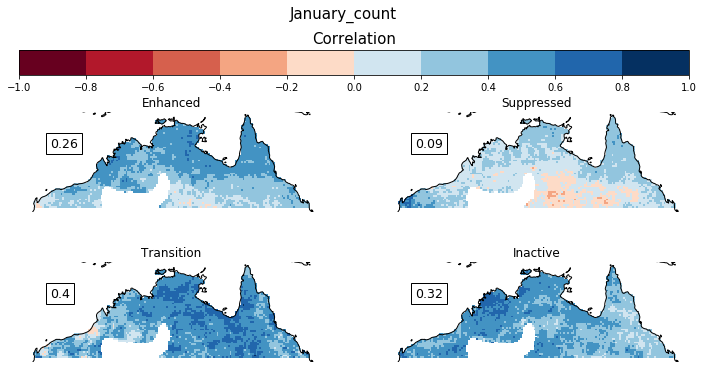

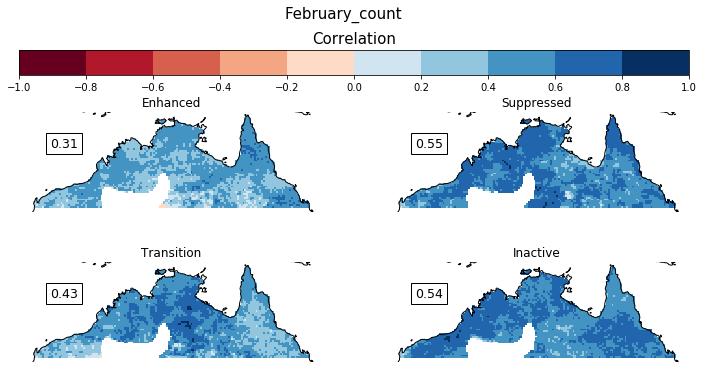

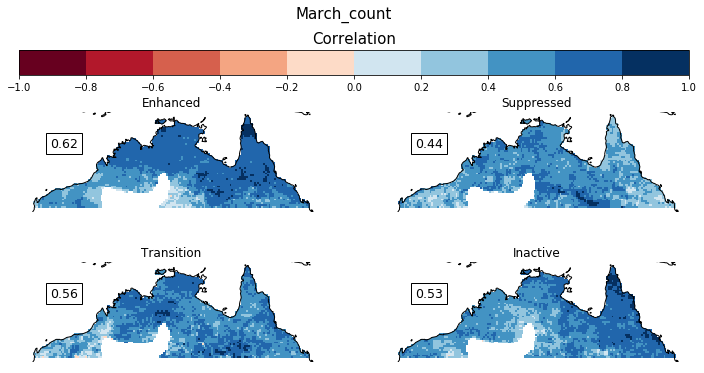

In [202]:
corr_plot = reload(corr_plot)
for month in [10,11,12,1,2,3]:
    save_name = f'{calendar.month_name[month]}_count'
    corr_plot.corr_plot(spearman_count.sel(month = month),means = spearman_mean.sel(month = month),
                        savetitle = save_name, savedir = savedir_count)

## MAE

In [217]:
awap_y_count

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, month: 6, phase: 4, year: 23)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2008 2009 2010 2011 2012
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * month    (month) int64 1 2 3 10 11 12
Data variables:
    precip   (phase, month, lat, lon, year) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0

In [218]:
access_y_count

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, month: 6, phase: 4, year: 23)
Coordinates:
  * lat      (lat) float32 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * lon      (lon) float32 113.75 114.0 114.25 114.5 ... 150.25 150.5 150.75
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2008 2009 2010 2011 2012
  * month    (month) int64 1 2 3 10 11 12
Data variables:
    precip   (phase, month, lat, lon, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [253]:
diff = awap_y_count - access_y_count

diff['precip'] = np.abs(diff.precip)

diff_nan = diff.where((awap_y_count != 0) & (access_y_count != 0))

median_diff = diff_nan.median(dim = 'year', skipna = True)

awap_median = awap_y_count.median(dim = 'year')

error = median_diff * 100/awap_median

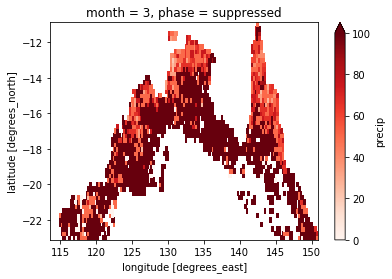

In [258]:
error.sel(phase = 'suppressed', month = 3).precip.plot(vmax = 100, cmap = 'Reds')

# Mean

In [87]:
awap_y_int = awap_split.apply(group_resample_mean)
awap_y_int

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, month: 6, phase: 4, year: 23)
Coordinates:
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2008 2009 2010 2011 2012
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * month    (month) int64 1 2 3 10 11 12
Data variables:
    precip   (phase, month, lat, lon, year) float32 nan nan nan ... nan nan nan

In [92]:
access_y_int = access_split.apply(group_resample_mean).median(dim = 'ensemble')
access_y_int

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, month: 6, phase: 4, year: 23)
Coordinates:
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2008 2009 2010 2011 2012
  * lat      (lat) float32 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * lon      (lon) float32 113.75 114.0 114.25 114.5 ... 150.25 150.5 150.75
  * month    (month) int64 1 2 3 10 11 12
Data variables:
    precip   (phase, month, lat, lon, year) float32 nan nan nan ... nan nan nan

In [93]:
rho_int = awap_access_correlation(awap_y_int, access_y_int)

## Plotting

In [98]:
savedir_int = 'plots_2/correlation/int/'

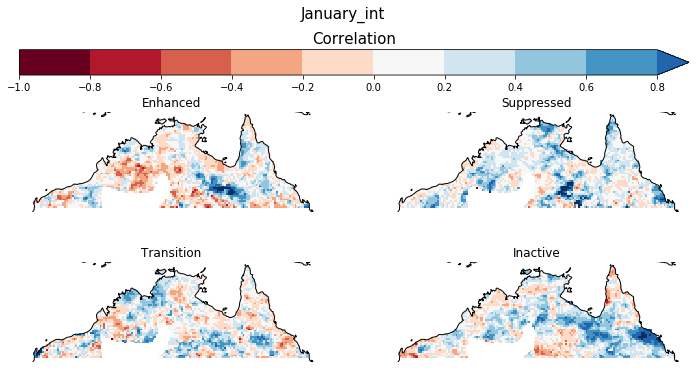

In [95]:
corr_plot = reload(corr_plot)
month = 1
save_name = f'{calendar.month_name[month]}_int'
corr_plot.corr_plot(rho_int.sel(month = month), savetitle = save_name)

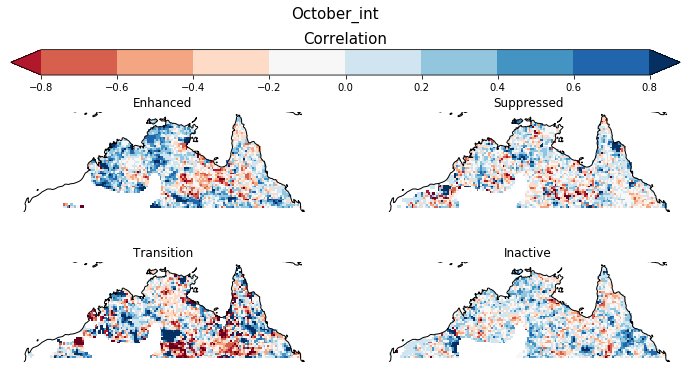

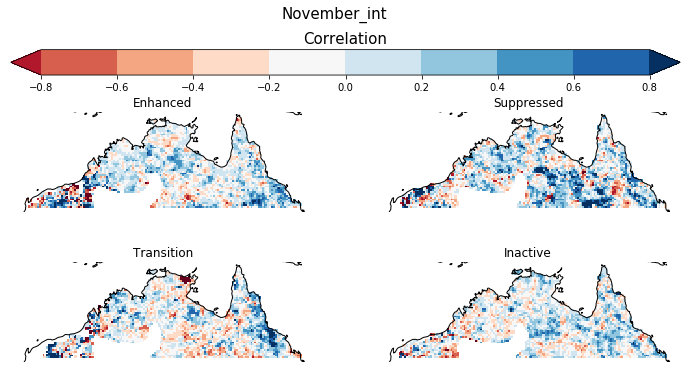

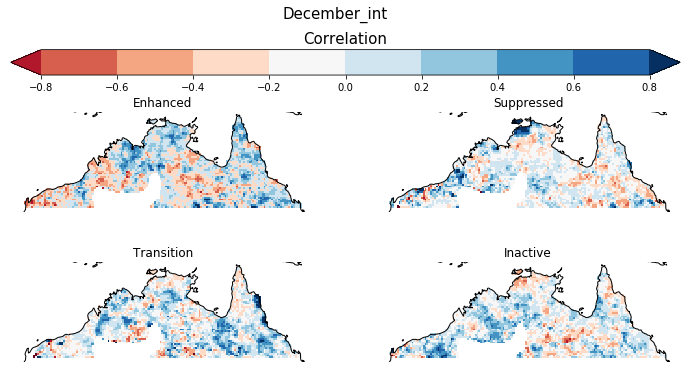

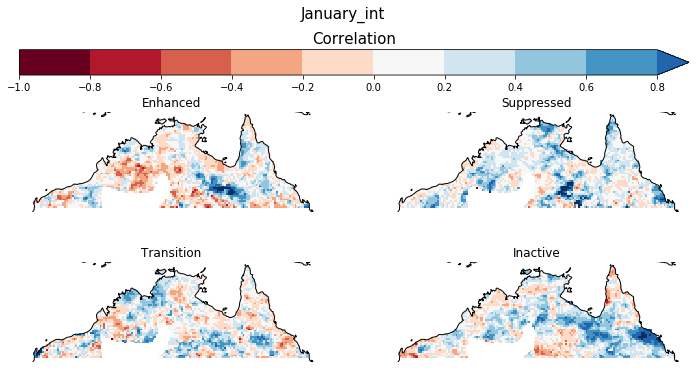

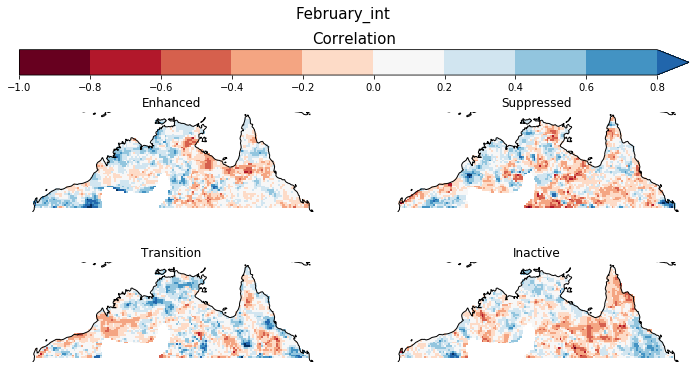

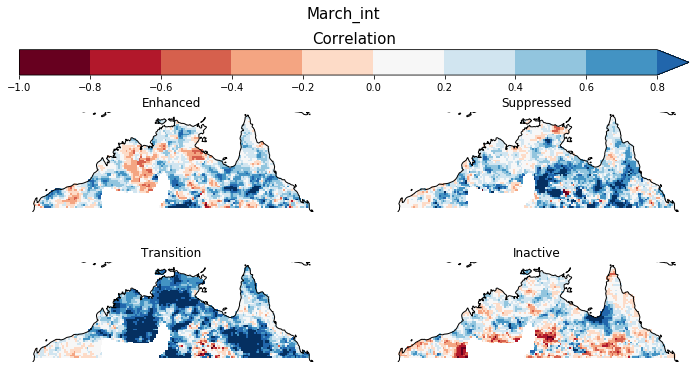

In [99]:
corr_plot = reload(corr_plot)
for month in [10,11,12,1,2,3]:
    save_name = f'{calendar.month_name[month]}_int'
    corr_plot.corr_plot(rho_int.sel(month = month), savetitle = save_name, savedir = savedir_int)

# Sum

In [102]:
awap_y_sum = awap_split.apply(group_resample_sum)


access_y_sum = access_split.apply(group_resample_sum).median(dim = 'ensemble')


rho_sum = awap_access_correlation(awap_y_sum, access_y_sum)

## Plotting

In [105]:
savedir_sum = 'plots_2/correlation/sum/'

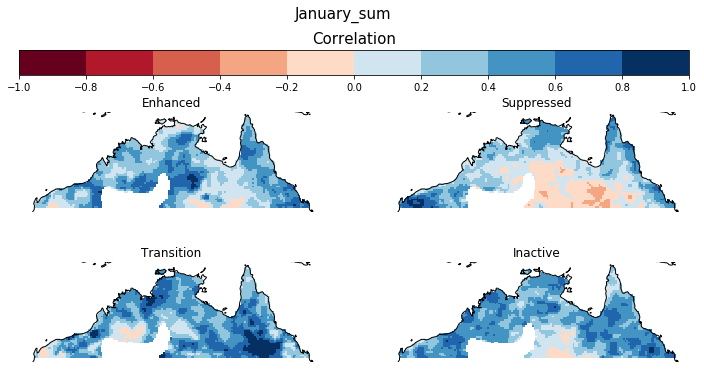

In [103]:
corr_plot = reload(corr_plot)
month = 1
save_name = f'{calendar.month_name[month]}_sum'
corr_plot.corr_plot(rho_sum.sel(month = month), savetitle = save_name)

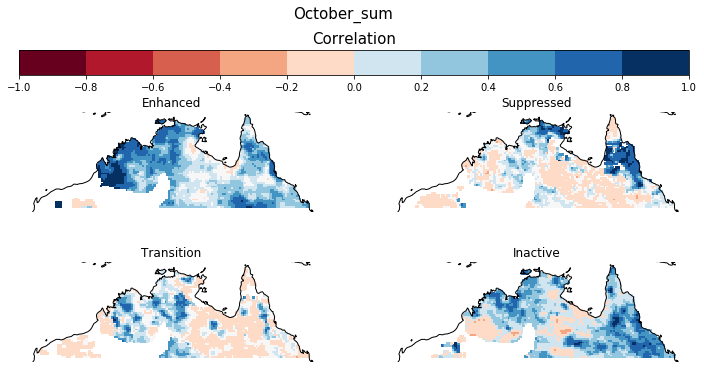

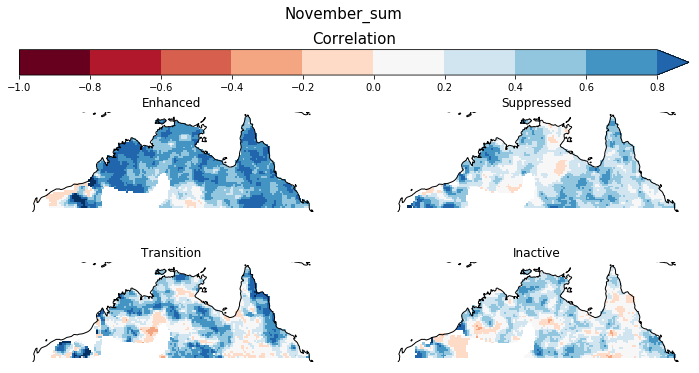

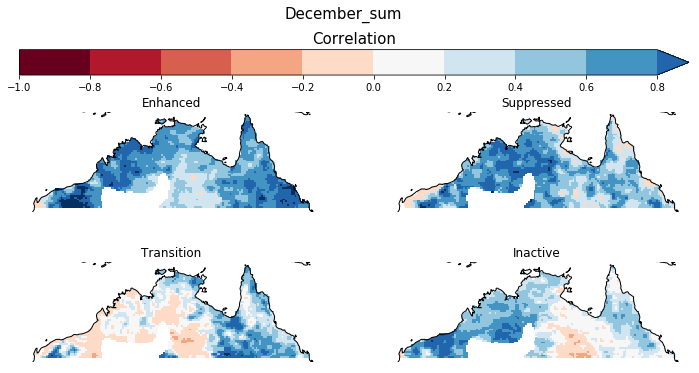

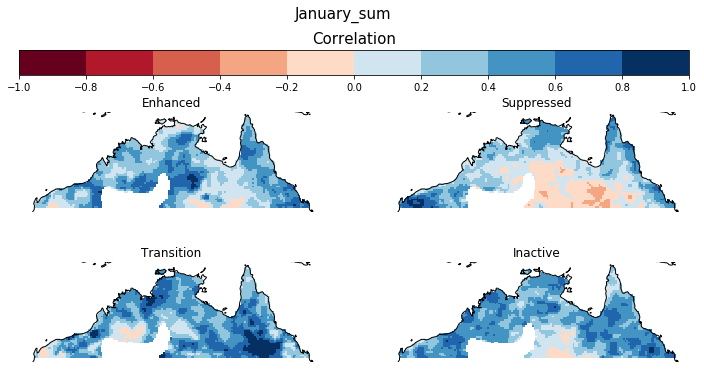

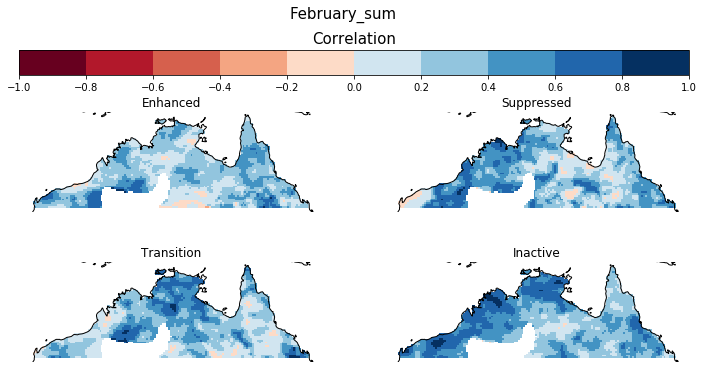

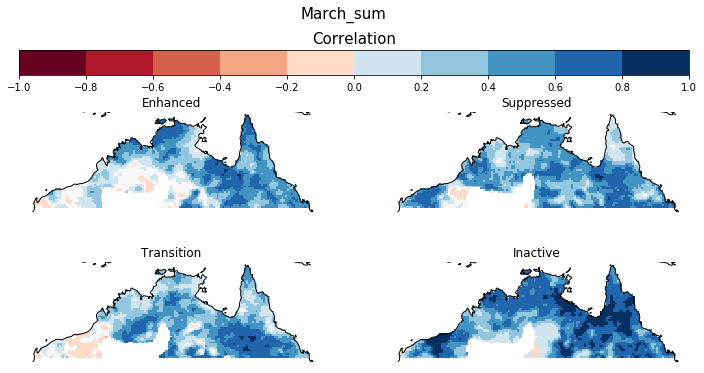

In [106]:
corr_plot = reload(corr_plot)
for month in [10,11,12,1,2,3]:
    save_name = f'{calendar.month_name[month]}_sum'
    corr_plot.corr_plot(rho_sum.sel(month = month), savetitle = save_name, savedir = savedir_sum)

# All Index

In [123]:
savedir_all = 'plots_2/correlation/all_index/'

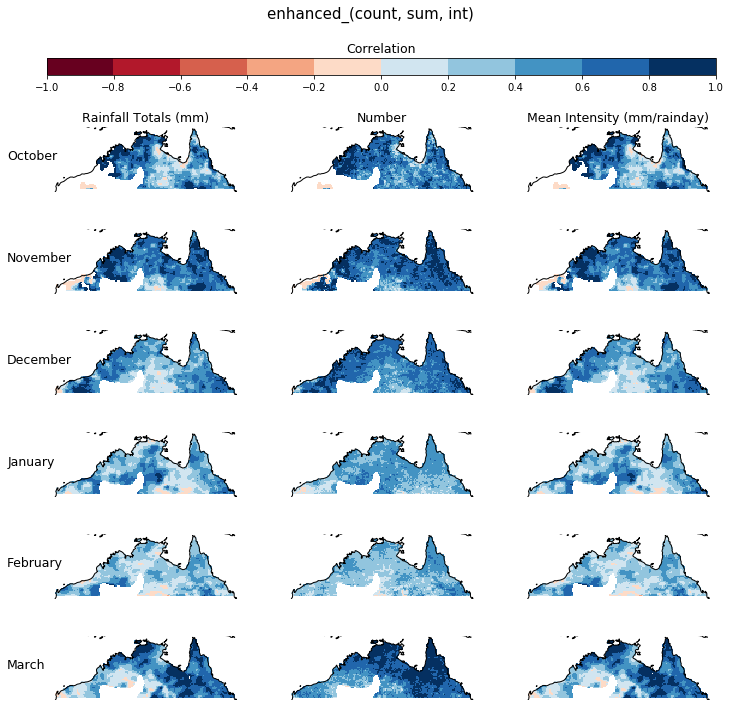

In [122]:
corr_plot = reload(corr_plot)
phase = 'enhanced'
savetitle = f'{phase}_(count, sum, int)'
corr_plot.correlation_plot_single_phase_multi_indinice([rho_sum, rho_count, rho_int],
                                             ['Rainfall Totals (mm)','Number','Mean Intensity (mm/rainday)'], 
                                                      savetitle = savetitle)

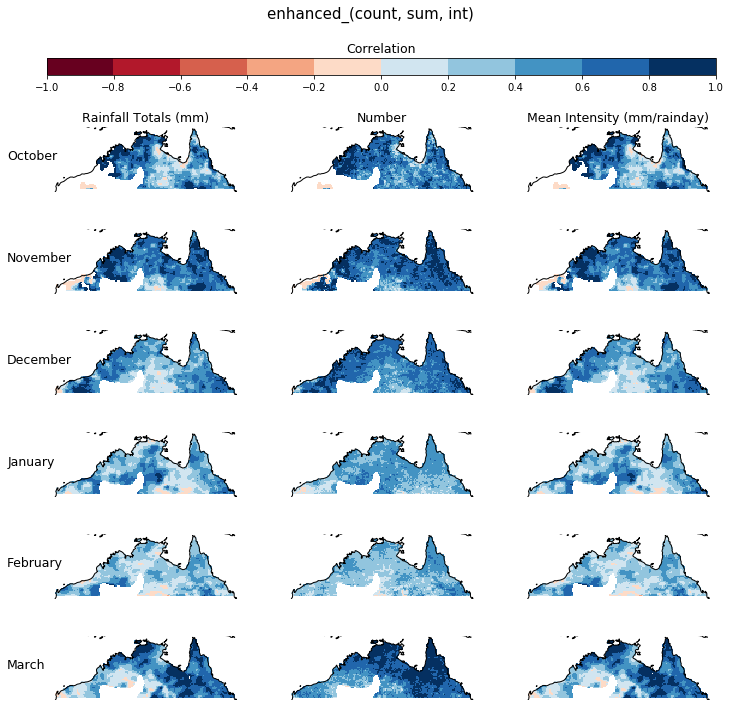

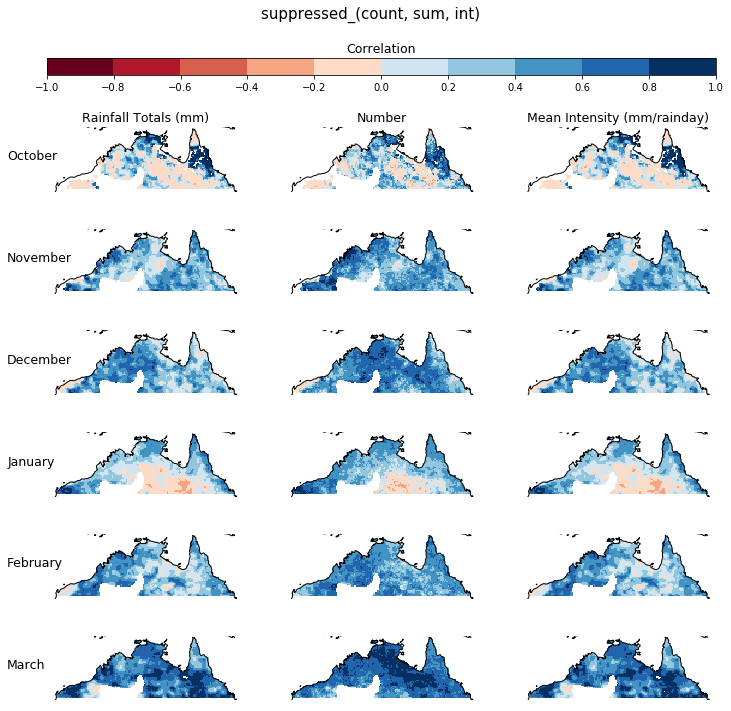

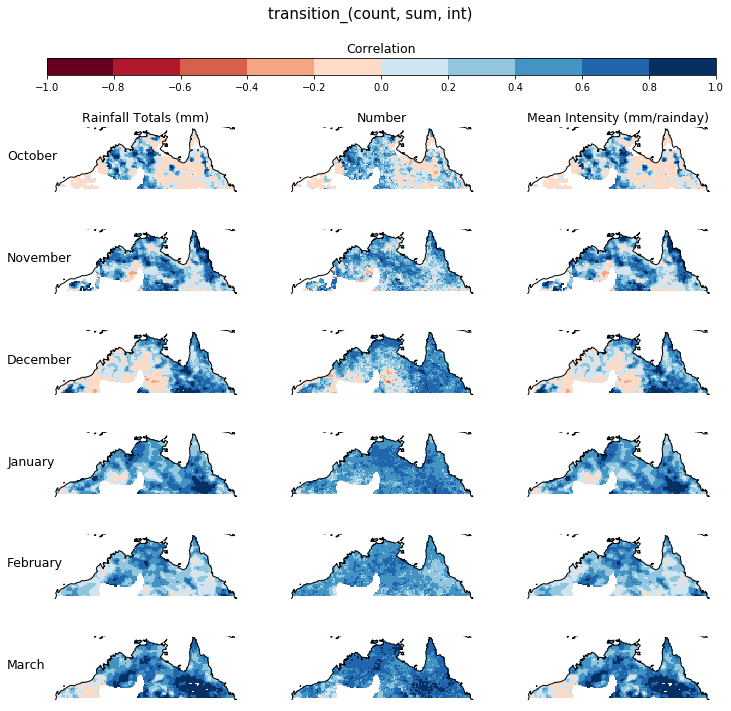

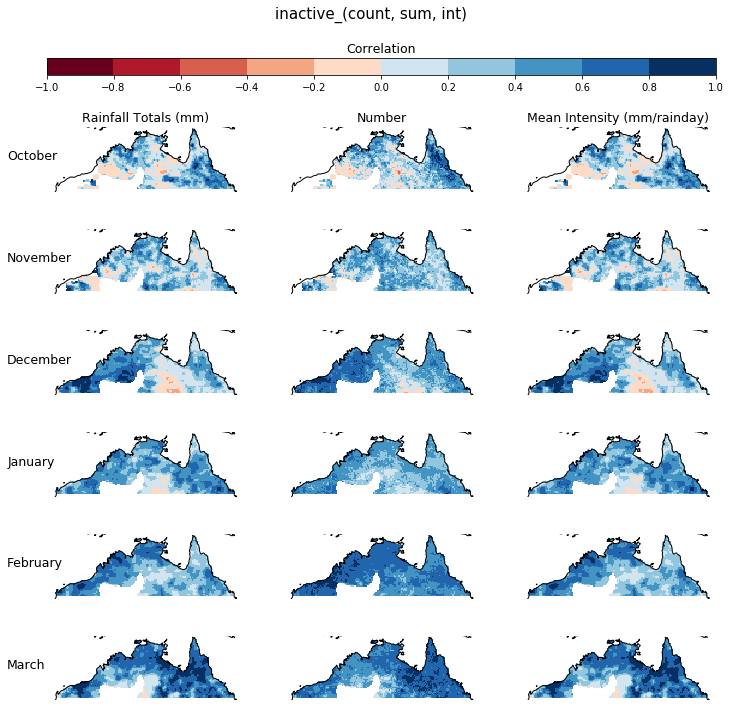

In [124]:
corr_plot = reload(corr_plot)
for phase in rho_sum.phase.values:
    savetitle = f'{phase}_(count, sum, int)'
    corr_plot.correlation_plot_single_phase_multi_indinice([rho_sum, rho_count, rho_int],
                                                 ['Rainfall Totals (mm)','Number','Mean Intensity (mm/rainday)'], 
                                                          savetitle = savetitle, phase = phase, 
                                                          savedir = savedir_all)